# A Director's impact on the bottom line

We primarily concerned with identifying any trends in the data regarding directors and top performing films. Key data points considered are film ratings, IMDB general film details and net revenue.

note: to create the movie.db locally, run the notebook SQLiteDatabase.ipynb

In [4]:
#necessary imports
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from glob import glob

#remove column truncation 
pd.set_option('display.max_columns', None)

## Correlations between films with the highest net revenue, ratings and directors

### What are the highest net revenue films?

In [3]:
conn = sqlite3.connect('movie.db') 
cur = conn.cursor()

cur.execute(""" 
SELECT 
  t.year as release_year, SUM(t.worldwide_gross-t.production_budget) as netRevenue_$,
  t.movie as film_title
FROM tn_movie_budgets t 
GROUP BY t.movie
ORDER BY netRevenue_$ DESC
LIMIT 5
;
""")

dft = pd.DataFrame(cur.fetchall())
dft.columns = (x[0] for x in cur.description)
#print(dft.shape)
#print(dft.info())

dft

,release_year,netRevenue_$,film_title
0,2009,2351345279,Avatar
1,1997,2008208395,Titanic
2,2018,1748134200,Avengers: Infinity War
3,2015,1747311220,Star Wars: Episode VII - The Force Awakens
4,2017,1687630838,Beauty and the Beast


The top 5 net revenue films are:

1. Avatar

2. Titanic

3. Avengers: Infinity War

4. Star Wars Ep. VII: The Force Awakens

5. Beauty and the Beast

#### Of the highest net revenue films, who are the directors?

In [38]:
conn = sqlite3.connect('movie.db') 
cur = conn.cursor()

cur.execute(""" 
SELECT c.tconst as movieID, nm.known_for_titles as knownFor_movieID, 
i.primary_title as movie_title, nm.primary_name as Director, 
nm.primary_profession, nm.birth_year
FROM imdb_title_crew c
LEFT JOIN imdb_title_basics i
ON c.tconst = i.tconst
LEFT JOIN tn_movie_budgets t 
ON i.primary_title = t.movie
LEFT JOIN imdb_name_basics nm
ON c.directors = nm.nconst OR c.director1 = nm.nconst OR 
c.director2 = nm.nconst
WHERE (i.primary_title == 'Beauty and the Beast') & (i.tconst == 'tt2771200') 
& (t.year like '%17%') OR (i.primary_title == 'Avatar') OR 
(i.primary_title == 'Titanic') OR (i.primary_title like '%Infinity War%') & 
(i.primary_title like '%Avengers%') OR (i.primary_title like '%Star War%') & 
(i.primary_title like '%Ep%') & (i.primary_title like '%Force Awakens%')
ORDER BY c.director1,c.director2,c.director3,c.director4
;
""")

dft = pd.DataFrame(cur.fetchall())
dft.columns = (x[0] for x in cur.description)
dft['wellKnown'] = dft.apply(lambda x: x.movieID in x.knownFor_movieID, axis=1)
print('directors are wellknown for thier work on these films?','\n',dft.wellKnown.value_counts())
#print(dft.shape)
#print(dft.info())

dft

directors are wellknown for thier work on these films? 
 True     7
False    1
Name: wellKnown, dtype: int64


,movieID,knownFor_movieID,movie_title,Director,primary_profession,birth_year,wellKnown
0,tt1775309,"tt1594549,tt1775309,tt1602612",Avatar,Atsushi Wada,director,NaN,True
1,tt2771200,"tt0362269,tt0443489,tt0120684,tt0299658",Beauty and the Beast,Bill Condon,"director,writer,producer",1955.0,False
2,tt2488496,"tt0411008,tt0796366,tt1650062,tt2488496",Star Wars: Episode VII - The Force Awakens,J.J. Abrams,"producer,writer,music_department",1966.0,True
3,tt8852130,tt8852130,Titanic,Ravi Punj,"director,writer,producer",NaN,True
4,tt4154756,"tt1843866,tt4154756,tt3498820,tt4154796",Avengers: Infinity War,Anthony Russo,"producer,director,writer",1970.0,True
5,tt4154756,"tt4154756,tt4154796,tt1843866,tt3498820",Avengers: Infinity War,Joe Russo,"producer,director,writer",1971.0,True
6,tt2495766,"tt3381008,tt3171832,tt3495026,tt2495766",Titanic,Pete Meads,"actor,camera_department,miscellaneous",NaN,True
7,tt2495766,tt2495766,Titanic,Kevin Lincoln,"director,actor,writer",NaN,True


***Findings***: The directors are:
* Atsushi Wada, 'Avatar'
* Anthony Russo and Joe Russo, 'Avengers: Infinity War'
* Bill Condon, 'Beauty and the Beast'
* J.J. Abrams, 'Star Wars: Episode VII - The Force Awakens'
* Ravi Punj, Pete Meads and Kevin Lincoln, 'Titanic'


#### Are these directors well known for their work on these films?

***Findings***: Nearly all the directors are well known for their work on the top net revenue films. By reviewing whether the movieID is contained in the list of knownFor_movieID, we can see that 'Beauty and the Beast' is the outlier. Bill Condon is well known for other films but not for his work on this particular film.

### What are the top flims as rated by viewers?

In [10]:
conn = sqlite3.connect('movie.db') 
cur = conn.cursor()

cur.execute(""" 
SELECT title, vote_average as viewer_Ratings
FROM tmdb_movies
WHERE vote_count >= '10000'
ORDER BY vote_average DESC;""")

pd.set_option('display.max_columns', None)
dft = pd.DataFrame(cur.fetchall())
dft.columns = (x[0] for x in cur.description)
#print(dft.shape)
#print(dft.info())
dft.head()

,title,viewer_Ratings
0,Inception,8.3
1,Avengers: Infinity War,8.3
2,The Lion King,8.2
3,Interstellar,8.2
4,Shutter Island,8.1


***Findings***: We can see that the top 5 user-rated films from TheMovieDB.org are:
1. Inception

2. Avengers: Infinity Wars

3. The Lion King

4. Interstellar

5. Shutter Island

Of these top user-rated films, the only film that is also in the top 5 films for net revenue is 'Avengers: Infinity Wars'.

#### Of the top-rated films, who are the directors?

In [16]:
conn = sqlite3.connect('movie.db') 
cur = conn.cursor()

cur.execute(""" 
SELECT t.vote_average as viewer_Ratings, t.title as movie_title, nm.primary_name as Director, 
nm.primary_profession, nm.birth_year
FROM tmdb_movies t
LEFT JOIN imdb_title_basics b
ON t.title = b.primary_title
LEFT JOIN imdb_title_crew c
USING (tconst)
LEFT JOIN imdb_name_basics nm
ON c.directors = nm.nconst OR c.director1 = nm.nconst OR 
c.director2 = nm.nconst
WHERE (t.vote_count >= '10000') & (viewer_Ratings >= '7')
ORDER BY vote_average DESC
;""")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
dft = pd.DataFrame(cur.fetchall())
dft.columns = (x[0] for x in cur.description)
#dft.occurance = df.apply(lambda x: x.Director)
#print(dft.shape)
#print(dft.info())
dft

,viewer_Ratings,movie_title,Director,primary_profession,birth_year
0,8.3,Inception,Christopher Nolan,"writer,producer,director",1970.0
1,8.3,Avengers: Infinity War,Anthony Russo,"producer,director,writer",1970.0
2,8.3,Avengers: Infinity War,Joe Russo,"producer,director,writer",1971.0
3,8.2,The Lion King,Jon Favreau,"producer,actor,miscellaneous",1966.0
4,8.2,Interstellar,Christopher Nolan,"writer,producer,director",1970.0
5,8.1,Shutter Island,Martin Scorsese,"producer,director,actor",1942.0
6,8.1,Harry Potter and the Deathly Hallows: Part 2,David Yates,"director,producer,writer",1963.0
7,8.1,The Imitation Game,Morten Tyldum,"director,producer,editor",1967.0
8,8.0,Django Unchained,Quentin Tarantino,"writer,actor,producer",1963.0
9,8.0,Inside Out,Artie Mandelberg,"producer,director,editor",NaN


#### Are these directors well known for their work on these films?

In [18]:
conn = sqlite3.connect('movie.db') 
cur = conn.cursor()

cur.execute(""" 
SELECT t.vote_average as viewer_Ratings, 
b.primary_title as movie_title, nm.primary_name as Director, 
nm.primary_profession, nm.birth_year, c.tconst as movieID, 
nm.known_for_titles as knownFor_movieID
FROM imdb_title_crew c
LEFT JOIN imdb_title_basics b
ON c.tconst = b.tconst
LEFT JOIN tn_movie_budgets t 
ON b.primary_title = t.movie
LEFT JOIN imdb_name_basics nm
ON c.directors = nm.nconst OR c.director1 = nm.nconst OR 
c.director2 = nm.nconst
LEFT JOIN tmdb_movies t
ON t.title = b.primary_title
WHERE (b.primary_title == 'Inception') OR (b.primary_title == 'The Lion King') OR 
(b.primary_title == 'Interstellar') OR (b.primary_title like '%Infinity War%') 
& (b.primary_title like '%Avengers%') OR (b.primary_title == 'Shutter Island')
ORDER BY c.director1,c.director2,c.director3,c.director4
;
""")

dft = pd.DataFrame(cur.fetchall())
dft.columns = (x[0] for x in cur.description)
dft['wellKnown'] = dft.apply(lambda x: x.movieID in x.knownFor_movieID, axis=1)
#print(dft.shape)
#print(dft.info())

dft

,viewer_Ratings,movie_title,Director,primary_profession,birth_year,movieID,knownFor_movieID,wellKnown
0,8.3,Inception,Christopher Nolan,"writer,producer,director",1970,tt1375666,"tt0482571,tt1375666,tt5013056,tt0154506",True
1,8.2,Interstellar,Christopher Nolan,"writer,producer,director",1970,tt0816692,"tt0482571,tt1375666,tt5013056,tt0154506",False
2,8.2,The Lion King,Jon Favreau,"producer,actor,miscellaneous",1966,tt6105098,"tt0117802,tt2883512,tt4154796,tt0371746",False
3,8.1,Shutter Island,Martin Scorsese,"producer,director,actor",1942,tt1130884,"tt0490215,tt0075314,tt0099685,tt0070379",False
4,8.3,Avengers: Infinity War,Anthony Russo,"producer,director,writer",1970,tt4154756,"tt1843866,tt4154756,tt3498820,tt4154796",True
5,8.3,Avengers: Infinity War,Joe Russo,"producer,director,writer",1971,tt4154756,"tt4154756,tt4154796,tt1843866,tt3498820",True


***Findings***: Only two movie titles have directors who are are well known for their work on these top 5 user-rated films:
1. Avengers: Infinity War

2. Inception

In [36]:
conn = sqlite3.connect('movie.db') 
cur = conn.cursor()

cur.execute(""" 
SELECT t.vote_average as viewer_Ratings, 
b.primary_title as movie_title, nm.primary_name as Director, 
nm.primary_profession, c.tconst as movieID, 
nm.known_for_titles as knownFor_movieID
FROM imdb_title_crew c
LEFT JOIN imdb_title_basics b
ON c.tconst = b.tconst
LEFT JOIN tn_movie_budgets t 
ON b.primary_title = t.movie
LEFT JOIN imdb_name_basics nm
ON c.directors = nm.nconst OR c.director1 = nm.nconst OR 
c.director2 = nm.nconst
LEFT JOIN tmdb_movies t
ON t.title = b.primary_title
WHERE (t.vote_count >= '10000') & (viewer_Ratings >= '7') & (movieID like '%tt%')
& (knownFor_movieID like '%tt%')
ORDER BY vote_average DESC
;
""")

dfknown = pd.DataFrame(cur.fetchall())
dfknown.columns = (x[0] for x in cur.description)
dfknown['wellKnown'] = dfknown.apply(lambda x: x.movieID in x.knownFor_movieID, axis=1)
print('directors are wellknown for thier work on these films?','\n',dfknown.wellKnown.value_counts())
#print(dft.shape)
#print(dft.info())

dfknown

directors are wellknown for thier work on these films? 
 True     70
False    15
Name: wellKnown, dtype: int64


,viewer_Ratings,movie_title,Director,primary_profession,movieID,knownFor_movieID,wellKnown
0,8.3,Avengers: Infinity War,Anthony Russo,"producer,director,writer",tt4154756,"tt1843866,tt4154756,tt3498820,tt4154796",True
1,8.3,Avengers: Infinity War,Joe Russo,"producer,director,writer",tt4154756,"tt4154756,tt4154796,tt1843866,tt3498820",True
2,8.3,Inception,Christopher Nolan,"writer,producer,director",tt1375666,"tt0482571,tt1375666,tt5013056,tt0154506",True
3,8.2,Interstellar,Christopher Nolan,"writer,producer,director",tt0816692,"tt0482571,tt1375666,tt5013056,tt0154506",False
4,8.2,The Lion King,Jon Favreau,"producer,actor,miscellaneous",tt6105098,"tt0117802,tt2883512,tt4154796,tt0371746",False
5,8.1,Harry Potter and the Deathly Hallows: Part 2,David Yates,"director,producer,writer",tt1201607,"tt0918940,tt0373889,tt1201607,tt0926084",True
6,8.1,The Imitation Game,Morten Tyldum,"director,producer,editor",tt2084970,"tt2084970,tt1355644,tt1614989,tt0371589",True
7,8.1,Shutter Island,Martin Scorsese,"producer,director,actor",tt1130884,"tt0490215,tt0075314,tt0099685,tt0070379",False
8,8.0,Inside Out,Vaggelis Rigas,"actor,assistant_director,director",tt1865538,"tt5336902,tt1865538,tt2428290,tt4248894",True
9,8.0,Inside Out,Russell Davidson,"writer,director,producer",tt8269544,"tt9214976,tt8269544,tt1820538,tt2372309",True


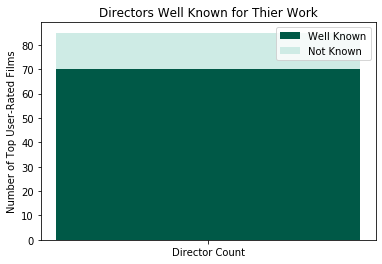

In [17]:
labels = ['Director Count']
well_known = [70]
not_known = [15]
width = 0.15       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, well_known, width, color="#005947", label='Well Known')
ax.bar(labels, not_known, width, color="#ceebe5", bottom=well_known,
       label='Not Known')

ax.set_ylabel('Number of Top User-Rated Films')
ax.set_title('Directors Well Known for Thier Work' )
ax.legend()

plt.show()

***Findings***: We can see that overwhelmingly directors are well known for their work on top user-rated films. This is 82% of the directors involved with films having a viewer rating of 7 or higher.

In [9]:
conn = sqlite3.connect('movie.db') 
cur = conn.cursor()

cur.execute(""" 
SELECT 
  t.year as release_year, SUM(t.worldwide_gross-t.production_budget) as netRevenue_$, 
  t.production_budget as productCost_$, t.movie as film_title
FROM tn_movie_budgets t 
WHERE (t.movie == 'Interstellar') OR (t.movie == 'Inception')
GROUP BY t.movie
ORDER BY netRevenue_$ DESC
LIMIT 5
;
""")

dft = pd.DataFrame(cur.fetchall())
dft.columns = (x[0] for x in cur.description)
#print(dft.shape)
#print(dft.info())

dft

,release_year,netRevenue_$,productCost_$,film_title
0,2010,675524642,160000000,Inception
1,2014,501379375,165000000,Interstellar


***Additional Findings***: Interestingly, the director for 'Inception', Christopher Nolan, also directed another top user-rated film 'Interstellar' but this film is not a top net revenue film. 'Interstellar' had nearly the same production cost as 'Inception' but trailed in net revenue by \\$17.4M.